<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(1)_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import Anndata objects for two biological replicates, SRR26046013 (cells treated with AOA inhibitor) and SRR26046019 (untreated cells)
Perform Differential accesibility analysis

In [2]:
!pip install -q condacolab

In [3]:
import condacolab

In [4]:
condacolab.install()

✨🍰✨ Everything looks OK!


In [5]:
!conda --version

conda 23.11.0


In [6]:
!which conda

/usr/local/bin/conda


In [7]:
!conda config --add channels conda-forge

In [8]:
!conda config --add channels bioconda

In [9]:
!pip install snapatac2 -q

In [10]:
!pip show snapatac2

Name: snapatac2
Version: 2.8.0
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [11]:
import snapatac2 as snap

In [12]:
!pip install umap-learn



In [13]:
import umap.umap_ as umap


In [14]:
from umap import UMAP

In [15]:
!pip install scanpy -q

In [16]:
import scanpy as sc

In [17]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: 
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [18]:
import numpy as np

In [19]:
import anndata as ad

In [20]:
!pip install diffxpy -q

In [21]:
import diffxpy.api as de

In [22]:
import matplotlib.pyplot as plt

In [23]:
import seaborn as sns

In [24]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [25]:
from scipy import stats

# Import reads from google drive

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
adata_concat = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/adata_concat.h5ad')

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [28]:
adata_concat

AnnData object with n_obs × n_vars = 11672 × 53588
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

# Differential accesibility analysis using scanpy

In [29]:
# Perform differential accessibility testing with Wilcoxon rank-sum test
sc.tl.rank_genes_groups(adata_concat, 'Treatment', method='wilcoxon')

# Access results in `adata_concat.uns['rank_genes_groups']`
# For example, to get the top differentially accessible regions:
top_dars = sc.get.rank_genes_groups_df(adata_concat, group='Treated w/AOA', pval_cutoff=0.05)

In [30]:
top_dars

,names,scores,logfoldchanges,pvals,pvals_adj
0,ENSG00000278791,7.998797,1.904730,1.256402e-15,3.502109e-15
1,MTCO3P12,7.983296,1.901616,1.424761e-15,3.968714e-15
2,MTATP6P1,7.934860,1.889212,2.107323e-15,5.848123e-15
3,CD3D,7.273932,0.567794,3.491712e-13,9.345414e-13
4,MTND6P35,6.894616,2.266840,5.401042e-12,1.413790e-11
...,...,...,...,...,...
27866,MAML3,-88.160477,-1.984729,0.000000e+00,0.000000e+00
27867,ZMIZ1,-88.445526,-2.462317,0.000000e+00,0.000000e+00
27868,RUNX1,-89.060822,-2.023931,0.000000e+00,0.000000e+00
27869,FOXP1,-89.468605,-2.028434,0.000000e+00,0.000000e+00


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


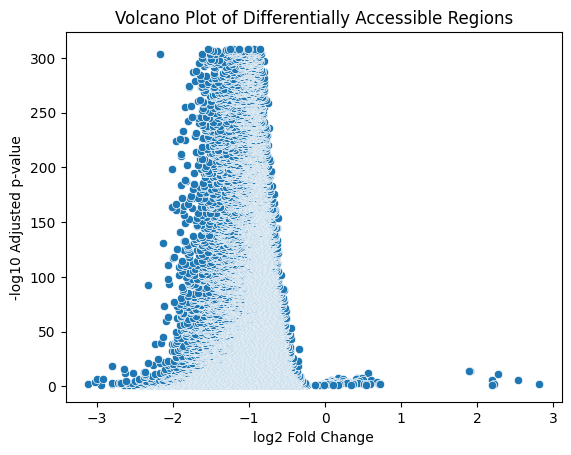

In [31]:
# Create scatterplot of differential accessibility results
sns.scatterplot(x=top_dars['logfoldchanges'], y=-np.log10(top_dars['pvals_adj']))
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 Adjusted p-value')
plt.title('Volcano Plot of Differentially Accessible Regions')
plt.show()

In [32]:
# Sort by adjusted p-value in ascending order (most significant first)
top_dars_sorted = top_dars.sort_values(by='pvals_adj')

# Select the top 10 rows
top_10_dars = top_dars_sorted.head(10)
bottom_10_dars = top_dars_sorted.tail(10)

In [33]:
# Display the top 10 DARs
print(top_10_dars)
print(bottom_10_dars)

                 names     scores  logfoldchanges  pvals  pvals_adj
27870  ENSG00000285708 -91.231148       -2.181107    0.0        0.0
26319        ADAM7-AS1 -43.084625       -1.475417    0.0        0.0
26318            NTNG2 -43.084198       -1.114267    0.0        0.0
26317            YWHAG -43.083111       -0.987811    0.0        0.0
26316             GLI2 -43.067299       -1.806581    0.0        0.0
26315           DUSP22 -43.067200       -1.117432    0.0        0.0
26314  ENSG00000284634 -43.062901       -1.049111    0.0        0.0
26320            PRKCZ -43.085884       -1.055056    0.0        0.0
26313             EML2 -43.060509       -1.183738    0.0        0.0
26311           CAMK2D -43.050148       -0.943554    0.0        0.0
              names    scores  logfoldchanges     pvals  pvals_adj
86  ENSG00000283355 -2.230343       -0.783072  0.025725   0.049477
85        RNU6-557P -2.228977       -1.155797  0.025815   0.049650
84  ENSG00000237371 -2.228603       -1.134785  0.02

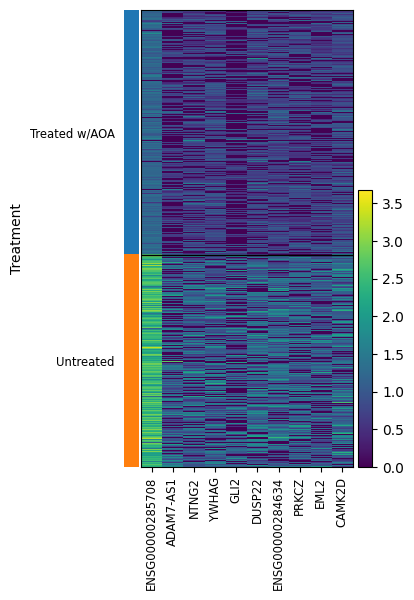

In [34]:
#Heatmap of top 10 differentially most expressed genes
sc.pl.heatmap(adata_concat, top_10_dars['names'].tolist(), groupby='Treatment', cmap='viridis')

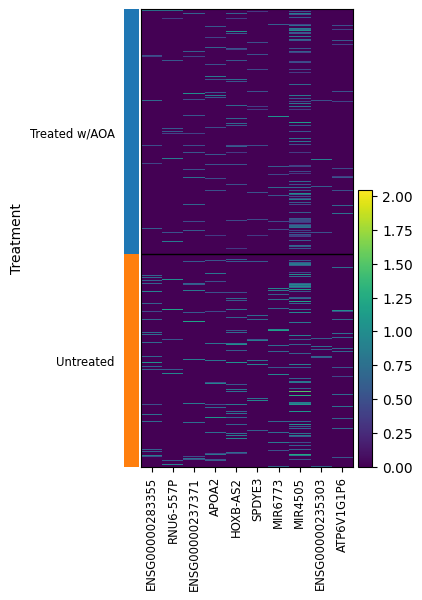

In [35]:
#Heatmap of top 10 differentially lowest expressed genes
sc.pl.heatmap(adata_concat, bottom_10_dars['names'].tolist(), groupby='Treatment', cmap='viridis')

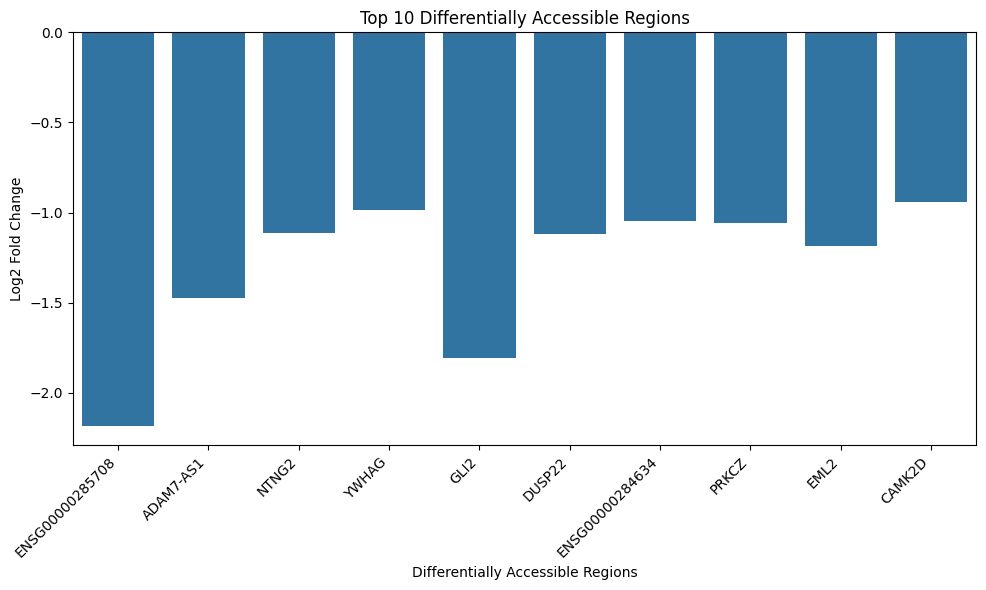

In [36]:
# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x=top_10_dars['names'].tolist(), y=top_10_dars['logfoldchanges'])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel('Differentially Accessible Regions')
plt.ylabel('Log2 Fold Change')
plt.title('Top 10 Differentially Accessible Regions')
plt.tight_layout()
plt.show()

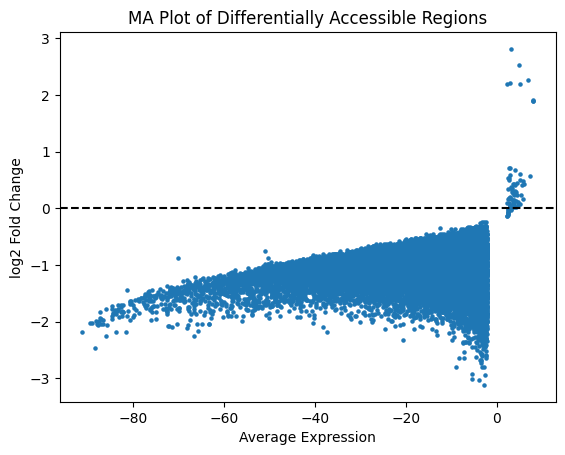

In [37]:
import matplotlib.pyplot as plt

# Assuming 'res_df' is your DataFrame of differential accessibility results
plt.scatter(top_dars['scores'], top_dars['logfoldchanges'], s=5)
plt.xlabel('Average Expression')
plt.ylabel('log2 Fold Change')
plt.title('MA Plot of Differentially Accessible Regions')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [38]:
adata_concat.var_names

Index(['DDX11L1', 'WASH7P', 'MIR1302-2HG', 'MIR1302-2', 'ENSG00000238009',
       'ENSG00000239945', 'DDX11L17', 'WASH9P', 'ENSG00000228463',
       'ENSG00000286448',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=53588)

Generating violin plots:   0%|          | 0/10 [00:00<?, ?it/s]

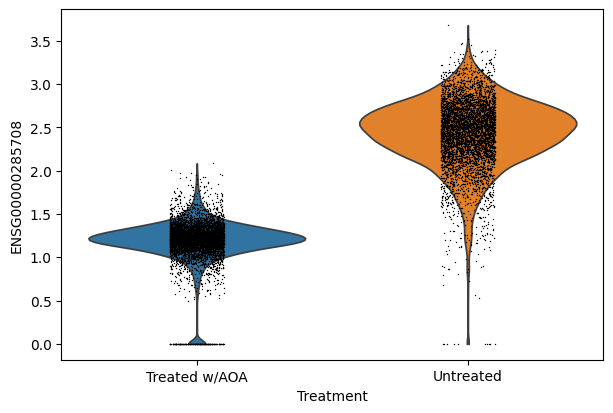

Generating violin plots:  10%|█         | 1/10 [00:00<00:05,  1.60it/s]

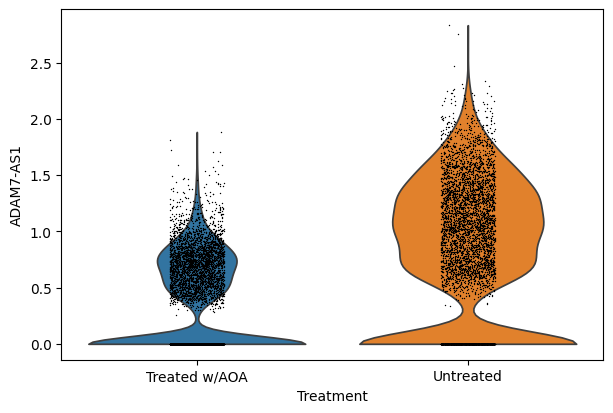

Generating violin plots:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

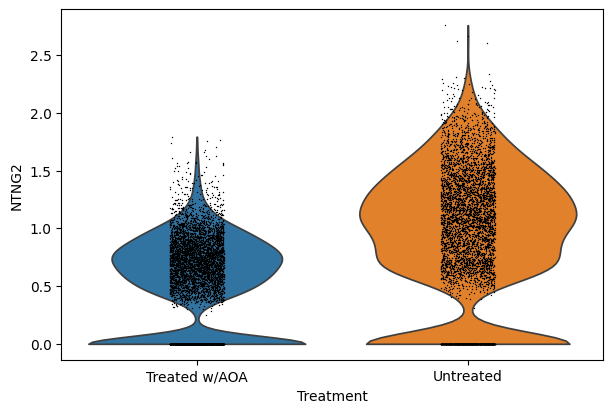

Generating violin plots:  30%|███       | 3/10 [00:01<00:04,  1.61it/s]

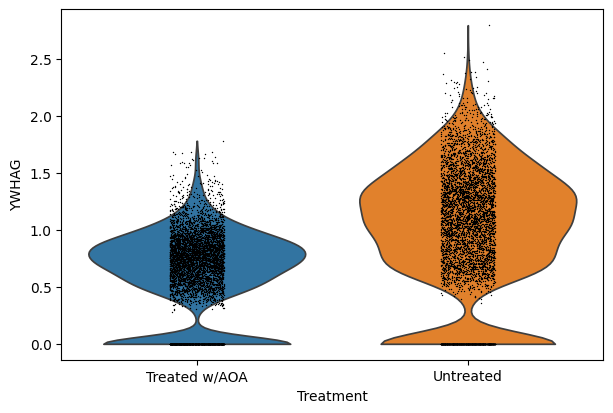

Generating violin plots:  40%|████      | 4/10 [00:02<00:03,  1.72it/s]

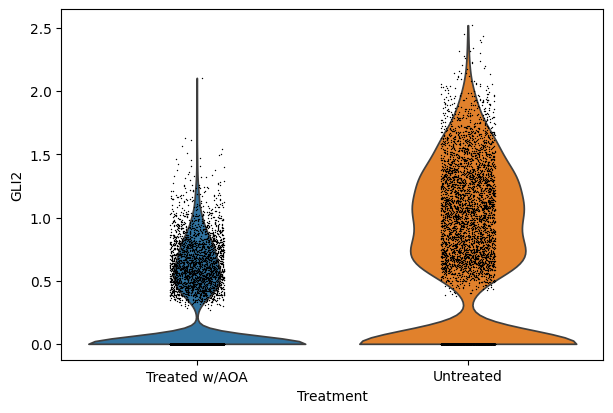

Generating violin plots:  50%|█████     | 5/10 [00:03<00:02,  1.68it/s]

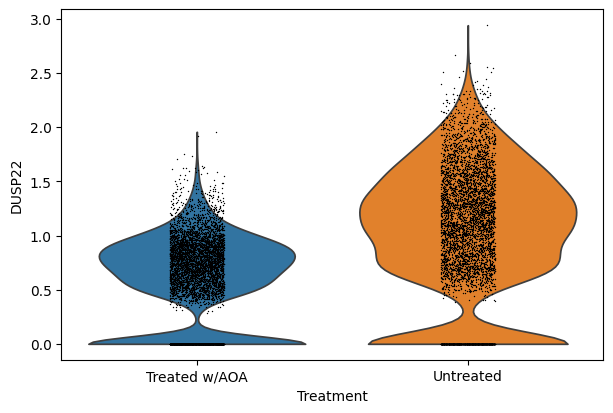

Generating violin plots:  60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

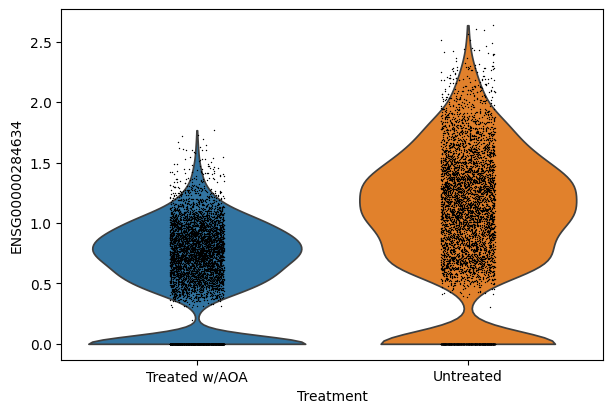

Generating violin plots:  70%|███████   | 7/10 [00:04<00:01,  1.84it/s]

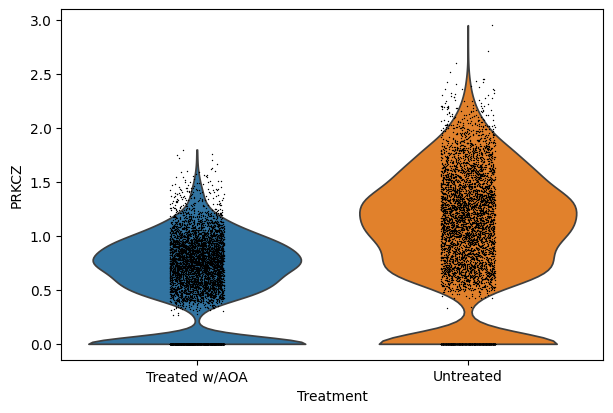

Generating violin plots:  80%|████████  | 8/10 [00:04<00:01,  1.91it/s]

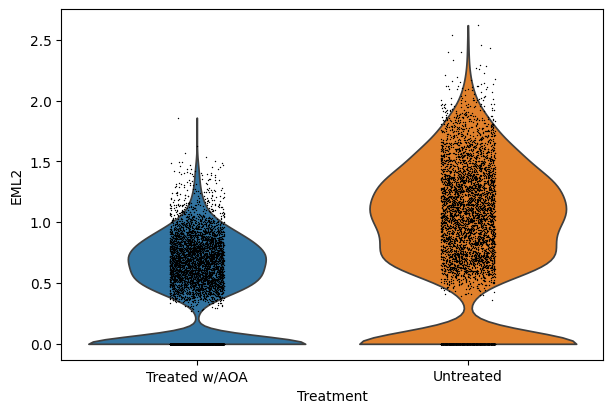

Generating violin plots:  90%|█████████ | 9/10 [00:04<00:00,  1.96it/s]

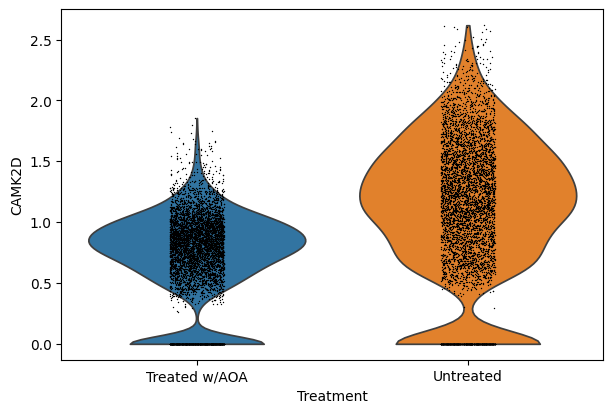

Generating violin plots: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


In [39]:
from tqdm import tqdm

for gene in tqdm(top_10_dars['names'].tolist(), desc="Generating violin plots"):
    sc.pl.violin(adata_concat, [gene], groupby='Treatment')

# Differential accessibility analysis using diffxpy

In [40]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import diffxpy.api as de

In [ ]:
!pip install tf

In [50]:
import diffxpy
print(diffxpy.__file__)

/usr/local/lib/python3.10/site-packages/diffxpy/__init__.py


In [52]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print(f"Current working directory: {current_directory}")

Current working directory: /content


In [56]:
#numpy type aliases
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

In [57]:
test_tt = de.test.t_test(
    data=adata_concat,
    grouping="Treatment"
)

In [61]:
test_tt.summary()

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,DDX11L1,0.999999,1.0,-1046.803853,-5.387499e-10,False,False
1,WASH7P,1.000000,1.0,0.000000,-9.198326e-09,False,False
2,MIR1302-2HG,0.999999,1.0,-1048.079533,8.420841e-09,False,False
3,MIR1302-2,0.999999,1.0,-1048.079533,8.420841e-09,False,False
4,ENSG00000238009,0.999999,1.0,-1045.981870,-3.955089e-09,False,False
...,...,...,...,...,...,...,...
53583,MT-ND6,1.000000,1.0,0.912236,6.633519e-09,False,False
53584,MT-TE,1.000000,1.0,-2.343741,6.133069e-09,False,False
53585,MT-CYB,1.000000,1.0,0.000000,-2.849502e-09,False,False
53586,MT-TT,1.000000,1.0,4.234340,5.050462e-09,False,False
